# Reducing Traffic Mortality in the USA

This project was done in september 2020. **Note to myself**: comments would be quite welcome to understand this project before I forget it. 

### Importing dependencies

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Importing the data and getting a quick glimpse at it

In [6]:
car_acc = pd.read_csv('road-accidents.csv', comment='#', sep='|')

print(f'There are {car_acc.shape[0]} rows and {car_acc.shape[1]} columns.\n')

car_acc_information = car_acc.info()
print(car_acc_information)

car_acc.tail(6)

There are 51 rows and 5 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 51 non-null     object 
 1   drvr_fatl_col_bmiles  51 non-null     float64
 2   perc_fatl_speed       51 non-null     int64  
 3   perc_fatl_alcohol     51 non-null     int64  
 4   perc_fatl_1st_time    51 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.1+ KB
None


,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
45,Vermont,13.6,30,30,95
46,Virginia,12.7,19,27,88
47,Washington,10.6,42,33,86
48,West Virginia,23.8,34,28,87
49,Wisconsin,13.8,36,33,84
50,Wyoming,17.4,42,32,90


### Statistical summary and preliminary graphical examination

       drvr_fatl_col_bmiles  perc_fatl_speed  perc_fatl_alcohol  \
count             51.000000        51.000000          51.000000   
mean              15.790196        31.725490          30.686275   
std                4.122002         9.633438           5.132213   
min                5.900000        13.000000          16.000000   
25%               12.750000        23.000000          28.000000   
50%               15.600000        34.000000          30.000000   
75%               18.500000        38.000000          33.000000   
max               23.900000        54.000000          44.000000   

       perc_fatl_1st_time  
count            51.00000  
mean             88.72549  
std               6.96011  
min              76.00000  
25%              83.50000  
50%              88.00000  
75%              95.00000  
max             100.00000  


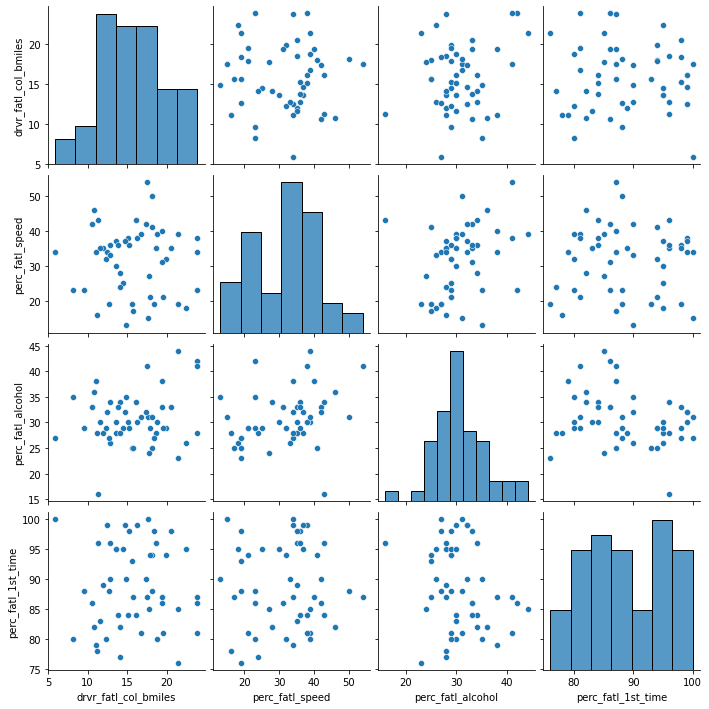

In [8]:
sum_stat_car = car_acc.describe()
print(sum_stat_car)

sns.pairplot(car_acc);

In [9]:
corr_columns = car_acc.corr() # to get a better idea of correlations in the data
corr_columns

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
drvr_fatl_col_bmiles,1.000000,-0.029080,0.199426,-0.017942
perc_fatl_speed,-0.029080,1.000000,0.286244,0.014066
perc_fatl_alcohol,0.199426,0.286244,1.000000,-0.245455
perc_fatl_1st_time,-0.017942,0.014066,-0.245455,1.000000


### First model: multivariate regression

In [11]:
features = car_acc.iloc[:, 2:]
target = car_acc.iloc[:, 1]

reg = linear_model.LinearRegression() # Create and fit the model
reg.fit(features, target)

fit_coef = reg.coef_ # Print the coefficients
fit_coef

array([-0.04180041,  0.19086404,  0.02473301])

We didn't standardize the data as this was only a preliminary model, but if we choose to use a regression it will of course be done.

### Further EDA: PCA

The cumulative variance of the first two principal components is 0.7947


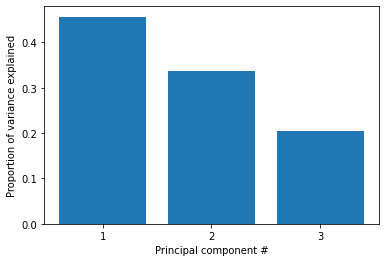

In [14]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA()
pca.fit(features_scaled) # Create and fit the standardized data

plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
plt.xlabel('Principal component #')
plt.ylabel('Proportion of variance explained')
plt.xticks([1, 2, 3])

two_first_comp_var_exp = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
print(f"The cumulative variance of the first two principal components is {round(two_first_comp_var_exp, 5)}")

Now we plot the data on these 2 first components

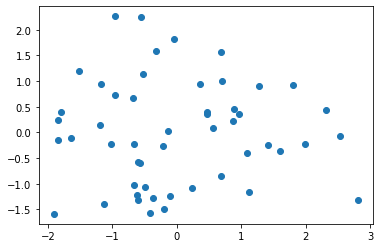

In [16]:
pca = PCA(n_components=2)
p_comps = pca.fit_transform(features_scaled)

p_comp1 = p_comps[:, 0]
p_comp2 = p_comps[:, 1]

plt.scatter(p_comp1, p_comp2);

### Clustering: identifying similar states in the data

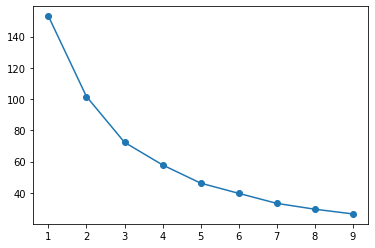

In [20]:
inertias = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=8)
    km.fit(features_scaled)
    inertias.append(km.inertia_)
    
plt.plot(ks, inertias, marker='o') # We loop over the different models to select the most axplanatory one

#### We can start by visualizing the clusters in the PCA plot

array([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 0,
       0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 0, 2,
       1, 1, 0, 2, 1, 2, 2])

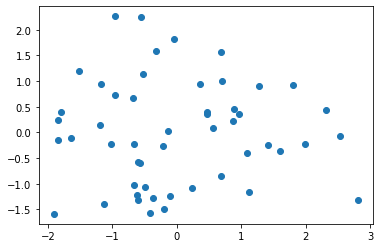

In [21]:
km = KMeans(n_clusters=3, random_state=42)

km.fit(features_scaled)

plt.scatter(p_comp1, p_comp2)
km.predict(features_scaled)

#### Now we visualize the feature importance in the three clusters

<AxesSubplot:xlabel='percent', ylabel='measurement'>

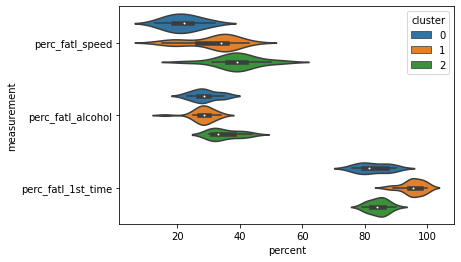

In [22]:
car_acc['cluster'] = km.labels_

melt_car = pd.melt(car_acc, id_vars=['cluster'], value_vars=features, 
                   var_name='measurement', value_name='percent') # reshaping to the long format

sns.violinplot(data=melt_car, x='percent', y='measurement', hue='cluster');

#### We now compute the accident numbers per cluster

,count,mean,sum
cluster,,,
0,12,920.385367,11044.6244
1,22,898.378595,19764.3291
2,17,872.132759,14826.2569


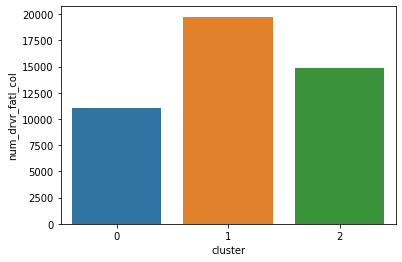

In [24]:
miles_driven = pd.read_csv('miles-driven.csv', sep='|')

car_acc_miles = car_acc.merge(miles_driven, on='state')
car_acc_miles['num_drvr_fatl_col'] = car_acc_miles['drvr_fatl_col_bmiles'] * car_acc_miles['million_miles_annually'] / 1000

sns.barplot(x='cluster', y='num_drvr_fatl_col', data=car_acc_miles, estimator=sum, ci=None)

count_mean_sum = car_acc_miles.groupby('cluster')['num_drvr_fatl_col'].agg(['count', 'mean', 'sum'], axis=0)
count_mean_sum

#### Therefore, we should focus policy efforts on cluster 2.